# Visualize Probed Activations — Pretrained GPT-2 Example

This script demonstrates how to **visualize** intermediate activations
probed from a pretrained GPT-2 model. It uses the visualization utilities
in ``captum._utils.transformer.visualization`` to produce:

1. **Heatmaps** of per-token, per-feature activation values
2. **Summary statistics** (mean ± std per token) across the feature dimension
3. **Distribution plots** comparing activation value distributions across different sub-modules
4. **Attention head heatmaps** showing query-key attention patterns for all heads, a single head, or a subset of heads in a layer

Prerequisites:
```
pip install captum transformers matplotlib
```

Usage:
```
python examples/visualize_activations_example.py
```

The script saves the figures to PNG files in the current directory
and also displays them if running interactively.

Note::
Attention weight extraction requires `output_attentions=True` and the `attn_implementation="eager"` setting in the model config, as SDPA / Flash Attention backends do not return per-head weights.

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from captum._utils.transformer.accessor import ActivationAccessor
from captum._utils.transformer.visualization import (
    visualize_activation_distribution,
    visualize_activation_stats,
    visualize_activations,
    visualize_attention_heads,
)

/home/xzhou185/Documents/XAI-kit/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

## 1. Load pretrained GPT-2
Use `attn_implementation="eager"` so attention weights are returned when `output_attentions=True`.

In [3]:
model_name = "gpt2"
print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, attn_implementation="eager"
)
model.eval()
print(
    f"Model loaded: "
    f"{sum(p.numel() for p in model.parameters()) / 1e6:.1f}M params"
)

Loading gpt2...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 1254.69it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded: 124.4M params


## 2. Tokenize input

In [4]:
text = "The quick brown fox jumps over the lazy dog"
input_ids = tokenizer(text, return_tensors="pt")["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print(f"Input: '{text}'")
print(f"Tokens: {tokens}")
print()

Input: 'The quick brown fox jumps over the lazy dog'
Tokens: ['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog']



## 3. Create accessor and extract activations

In [5]:
accessor = ActivationAccessor(model, "gpt2")

# Probe FFN internals in block 0
ffn_ids = ["L0.mlp.c_fc", "L0.mlp.act", "L0.mlp.c_proj"]
ffn_acts = accessor.get_multi_layer_activations(ffn_ids, input_ids)

# Probe attention internals in block 0
attn_ids = ["L0.attn.c_attn", "L0.attn.c_proj"]
attn_acts = accessor.get_multi_layer_activations(attn_ids, input_ids)

# Probe GELU activation across all 12 blocks
all_gelu_ids = [f"L{i}.mlp.act" for i in range(12)]
all_gelu_acts = accessor.get_multi_layer_activations(
    all_gelu_ids, input_ids
)

## 4. Visualization 1: FFN internals heatmap

Generating FFN activation heatmaps...


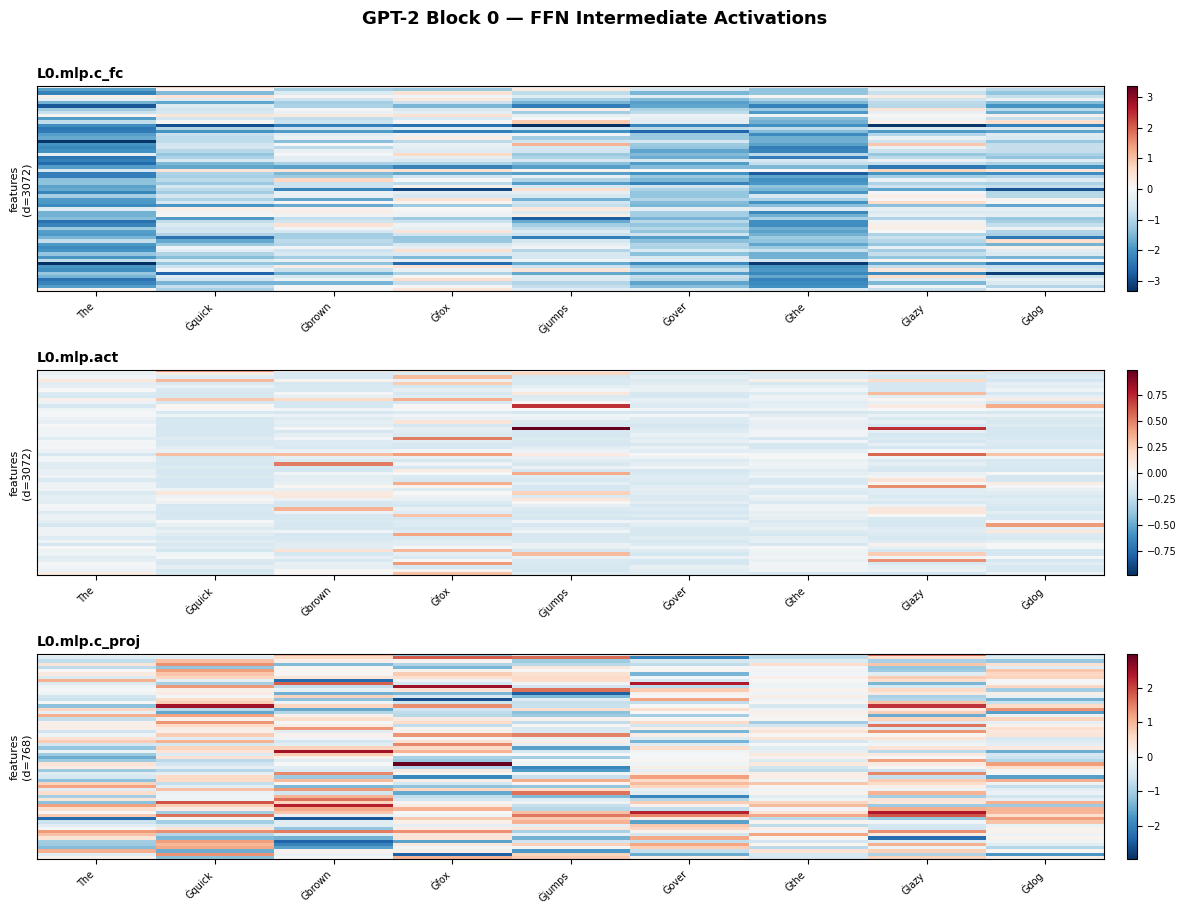

In [6]:
print("Generating FFN activation heatmaps...")
fig1 = visualize_activations(
    ffn_acts,
    tokens=tokens,
    title="GPT-2 Block 0 — FFN Intermediate Activations",
    use_pyplot=False,
)

## 5. Visualization 2: Attention internals heatmap

Generating attention activation heatmaps...


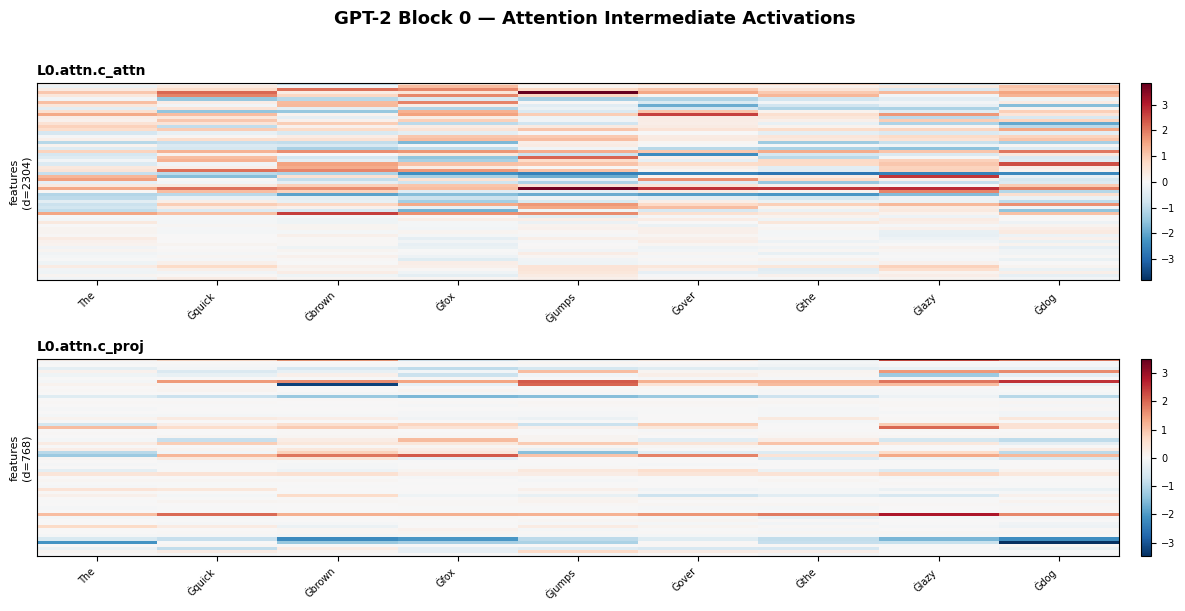

In [7]:
print("Generating attention activation heatmaps...")
fig2 = visualize_activations(
    attn_acts,
    tokens=tokens,
    title="GPT-2 Block 0 — Attention Intermediate Activations",
    use_pyplot=False,
)

## 6. Visualization 3: Per-token summary statistics

Generating per-token statistics chart...


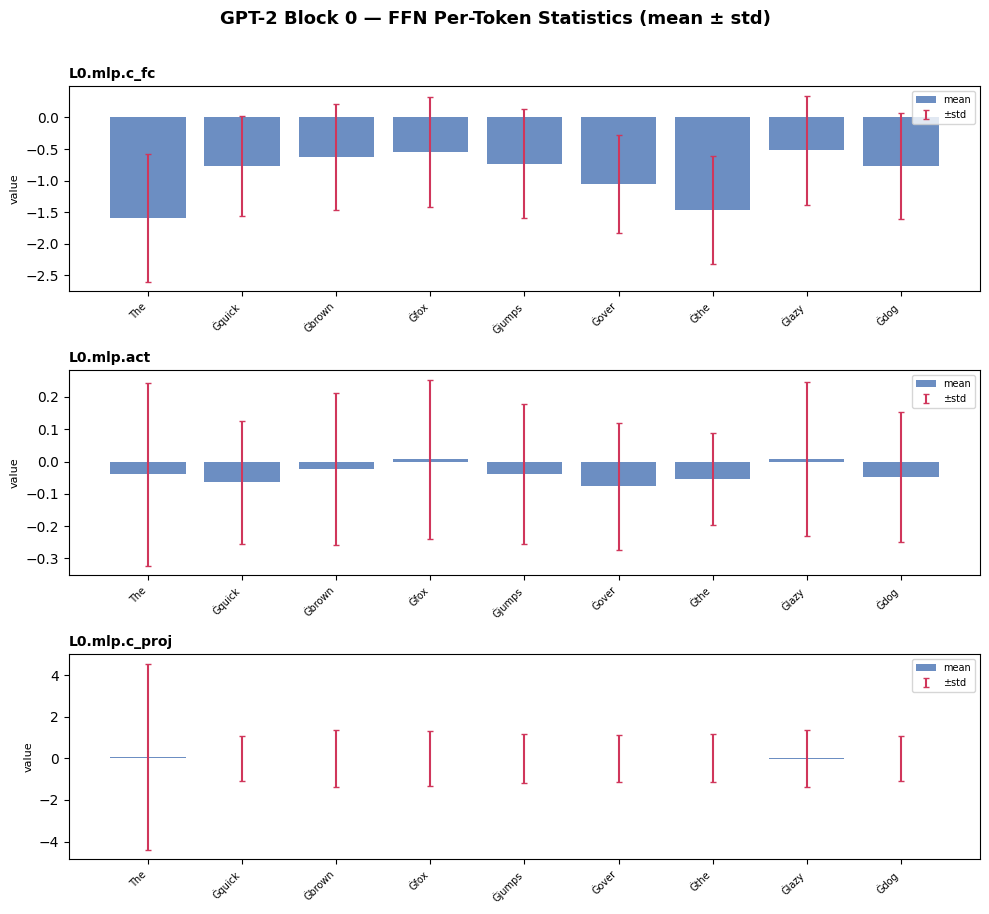

In [8]:
print("Generating per-token statistics chart...")
fig3 = visualize_activation_stats(
    ffn_acts,
    tokens=tokens,
    title="GPT-2 Block 0 — FFN Per-Token Statistics (mean ± std)",
    use_pyplot=False,
)

## 7. Visualization 4: Activation distribution comparison

Generating activation distribution plot...


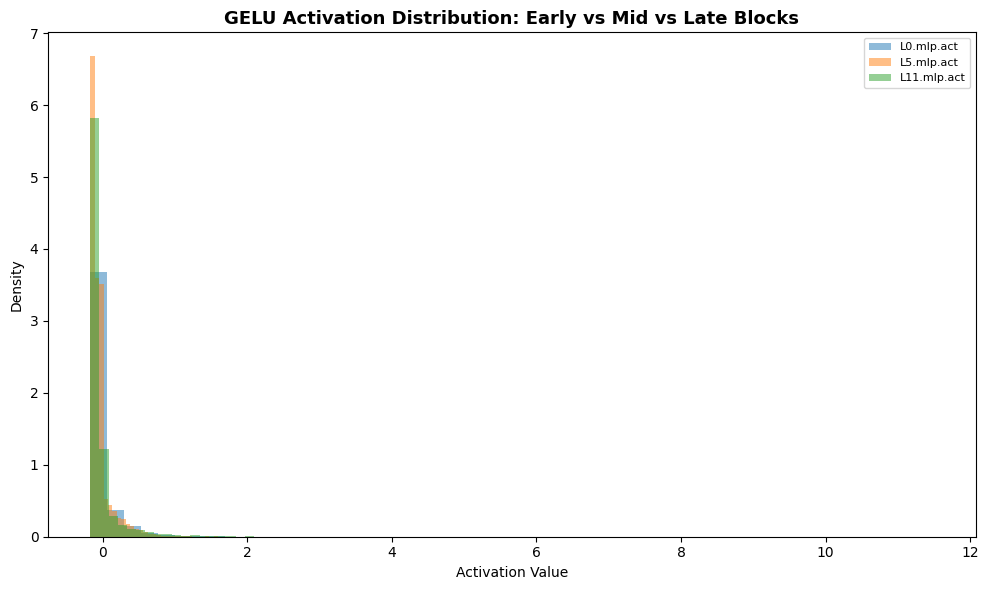

In [9]:
print("Generating activation distribution plot...")
# Compare GELU output distribution across early, mid, and late blocks
dist_acts = {
    "L0.mlp.act": all_gelu_acts["L0.mlp.act"],
    "L5.mlp.act": all_gelu_acts["L5.mlp.act"],
    "L11.mlp.act": all_gelu_acts["L11.mlp.act"],
}
fig4 = visualize_activation_distribution(
    dist_acts,
    title="GELU Activation Distribution: Early vs Mid vs Late Blocks",
    use_pyplot=False,
)

## 8. Visualization 5: All GELU activations across 12 blocks

Generating all-blocks GELU statistics...


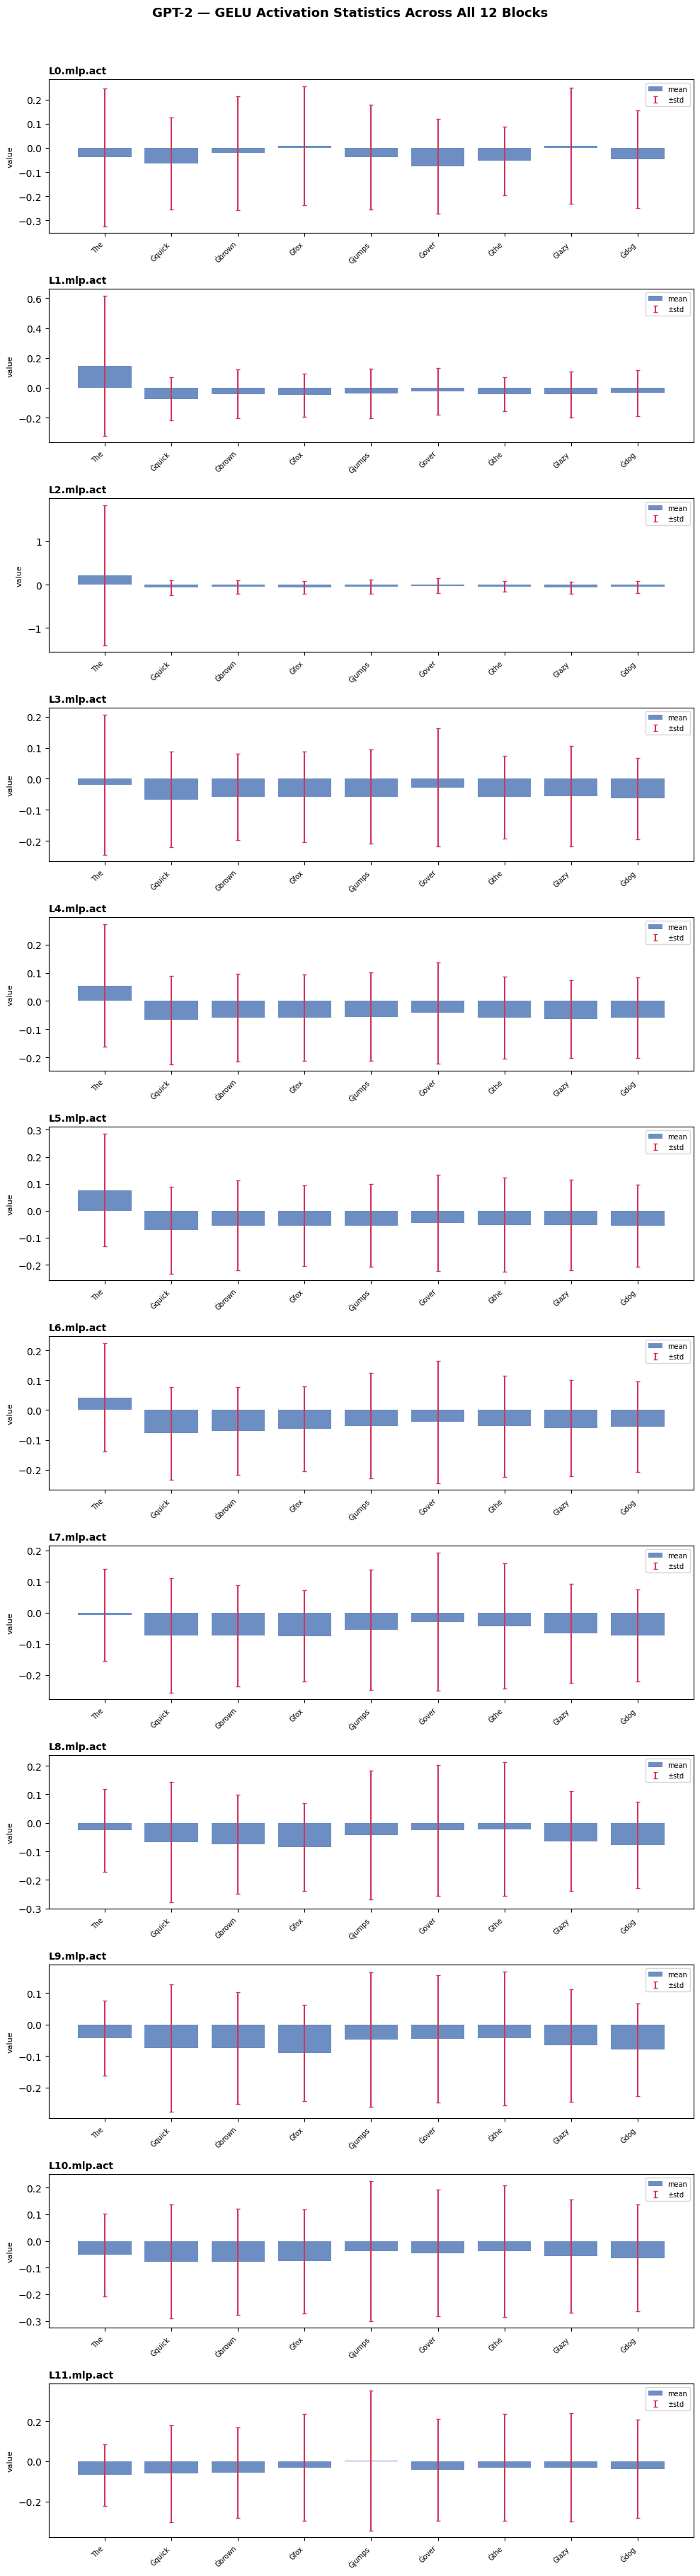

In [10]:
print("Generating all-blocks GELU statistics...")
fig5 = visualize_activation_stats(
    all_gelu_acts,
    tokens=tokens,
    title="GPT-2 — GELU Activation Statistics Across All 12 Blocks",
    use_pyplot=False,
)

## 9. Visualization 6: Attention heads — all heads in layer 0
`get_attention_weights()` hooks into the attention sub-module and captures the weight matrix `(batch, num_heads, seq_len, seq_len)`.

Extracting attention weights for layer 0...
  Attention weights shape: torch.Size([1, 12, 9, 9])
Generating attention heatmaps (all heads, layer 0)...


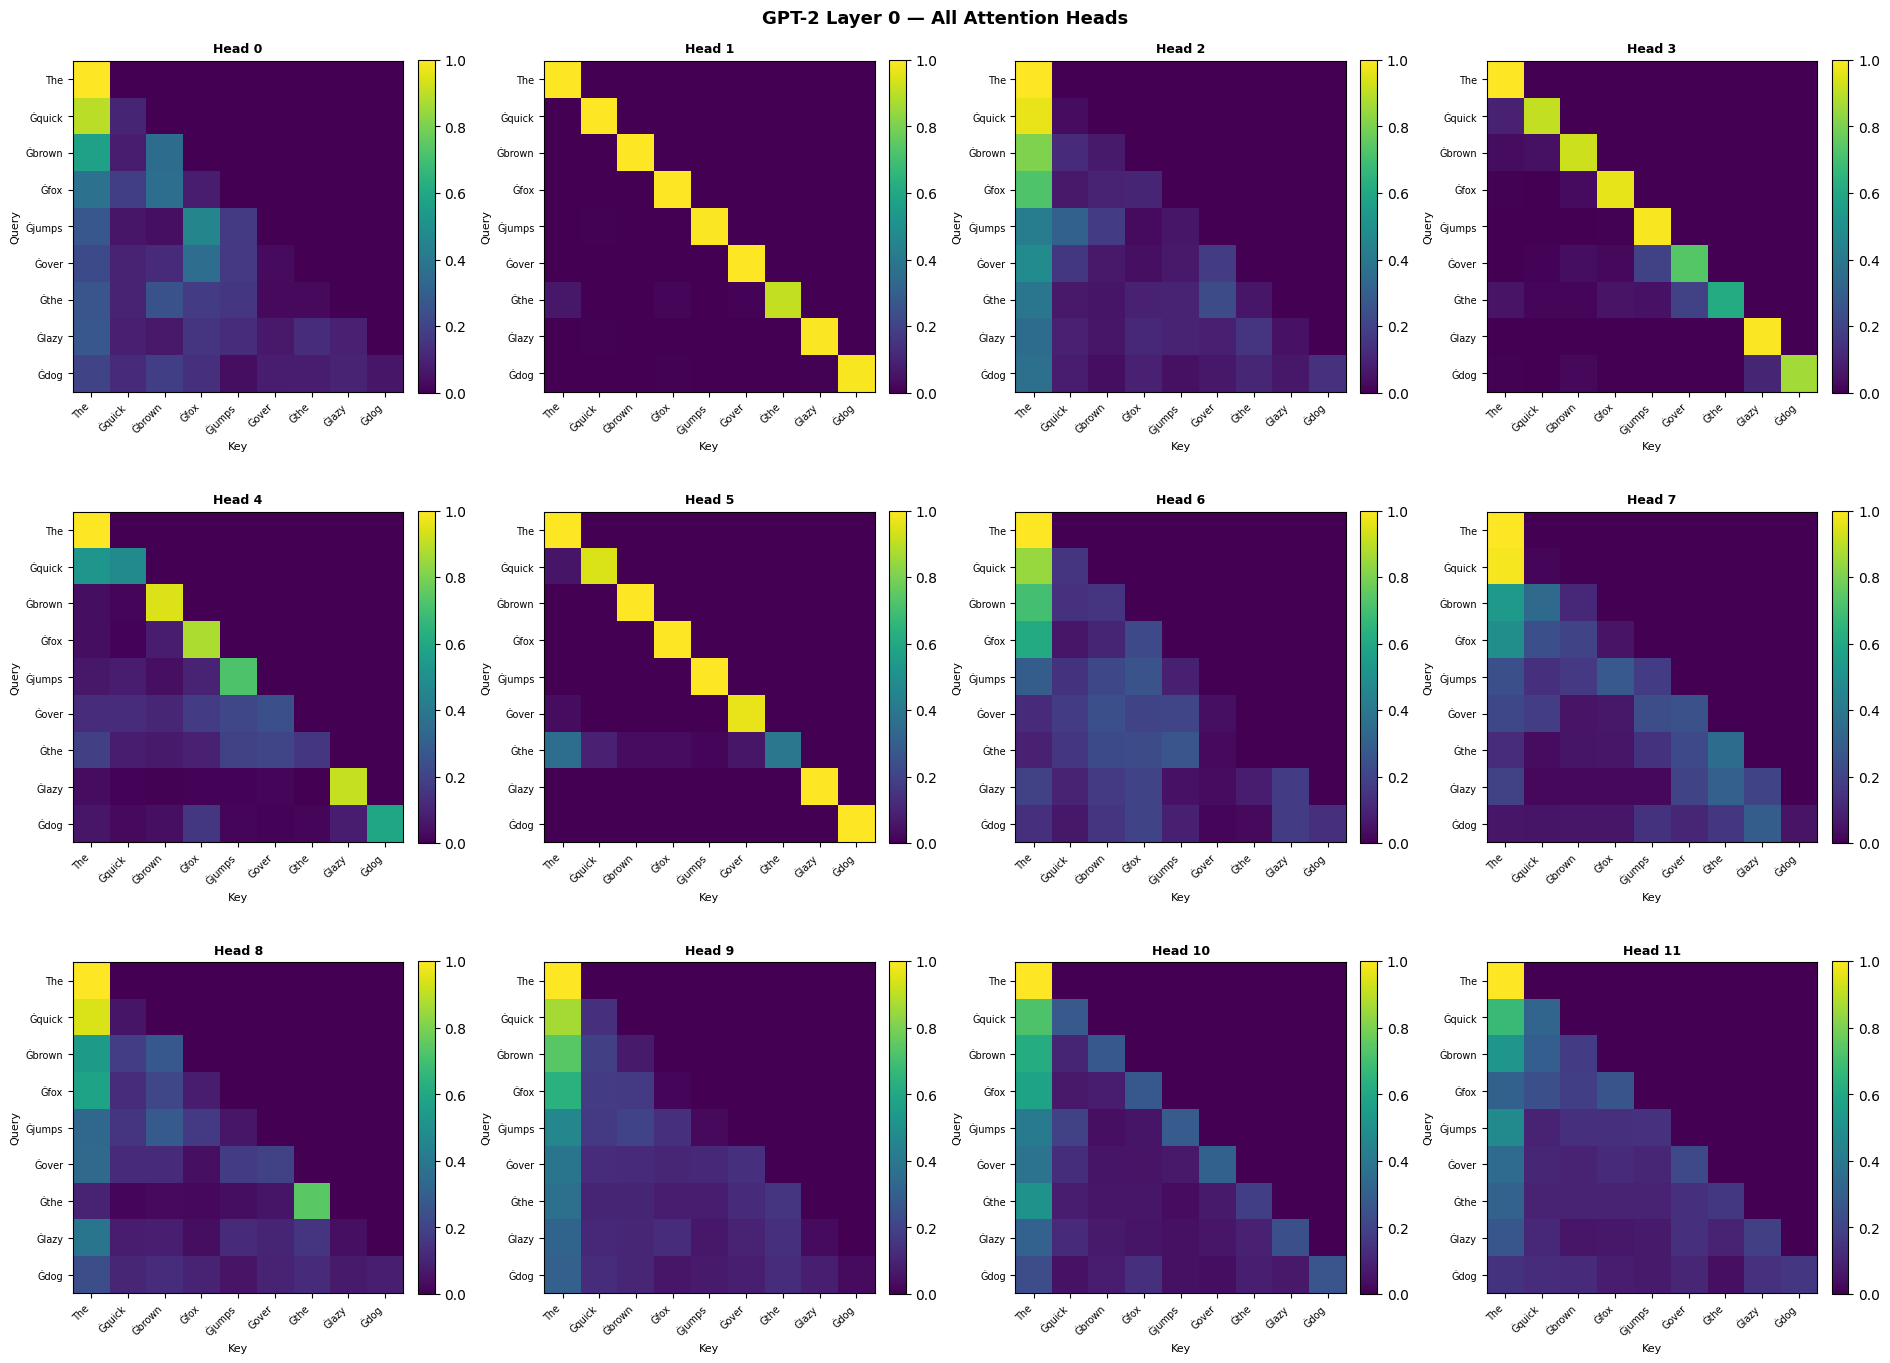

In [11]:
print("Extracting attention weights for layer 0...")
attn_weights_l0 = accessor.get_attention_weights(
    "L0", input_ids, output_attentions=True
)
print(f"  Attention weights shape: {attn_weights_l0.shape}")

print("Generating attention heatmaps (all heads, layer 0)...")
fig6 = visualize_attention_heads(
    attn_weights_l0,
    tokens=tokens,
    title="GPT-2 Layer 0 — All Attention Heads",
    use_pyplot=False,
)

## 10. Visualization 7: Attention heads — single head (head 3)

Generating attention heatmap (head 3, layer 0)...


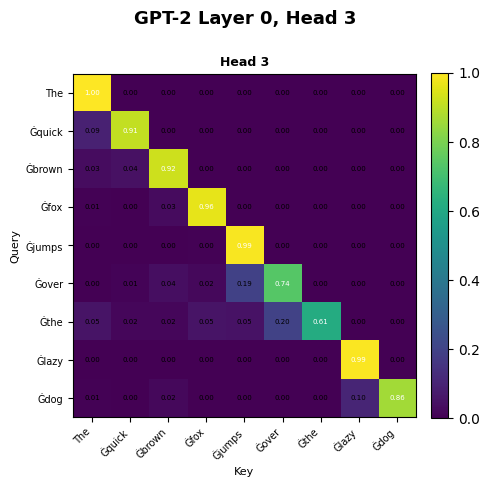

In [12]:
print("Generating attention heatmap (head 3, layer 0)...")
fig7 = visualize_attention_heads(
    attn_weights_l0,
    head=3,
    tokens=tokens,
    show_values=True,
    title="GPT-2 Layer 0, Head 3",
    use_pyplot=False,
)

## 11. Visualization 8: Attention heads — selected subset

Generating attention heatmaps (heads 0, 5, 11 — layer 0)...


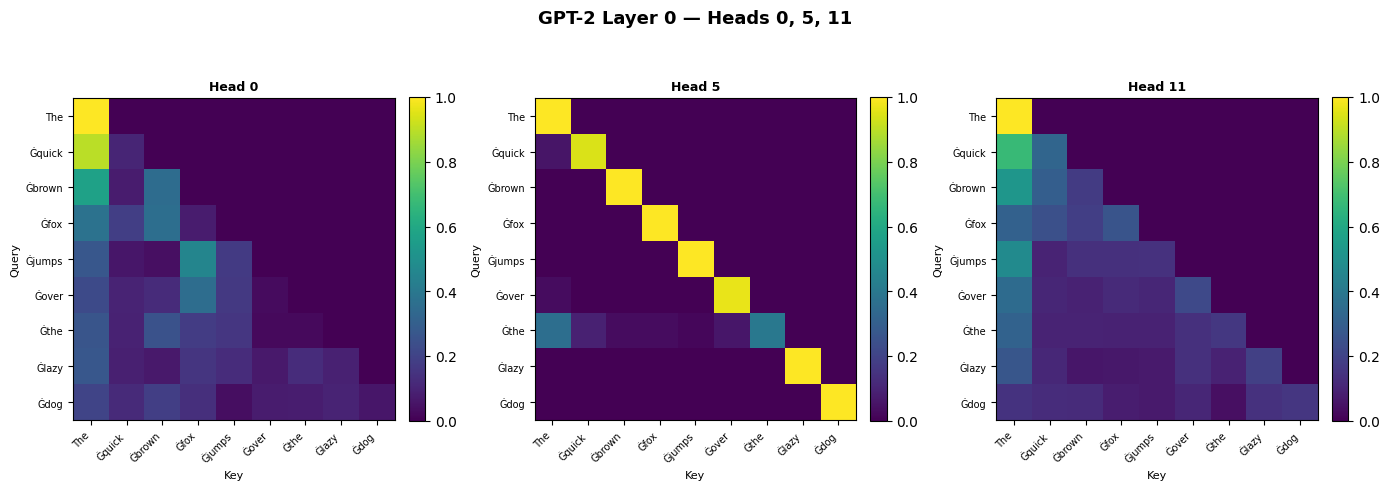

In [13]:
print("Generating attention heatmaps (heads 0, 5, 11 — layer 0)...")
fig8 = visualize_attention_heads(
    attn_weights_l0,
    head=[0, 5, 11],
    tokens=tokens,
    title="GPT-2 Layer 0 — Heads 0, 5, 11",
    use_pyplot=False,
)